In [1]:
# necessary imports
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import fftconvolve

1) Download a color image from the web. Run the SLIC superpixel segmentation
algorithm provided in Matlab or Python and experiment with the target number of
superpixels and compactness. Display and discuss your results. [3 pts]

In [2]:
img = plt.imread('hawa-mahal-out.jpg.webp')

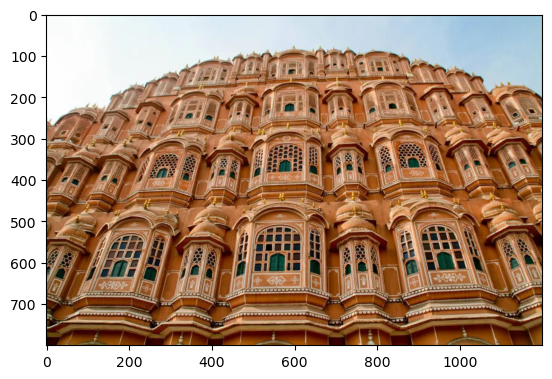

In [3]:
plt.imshow(img)

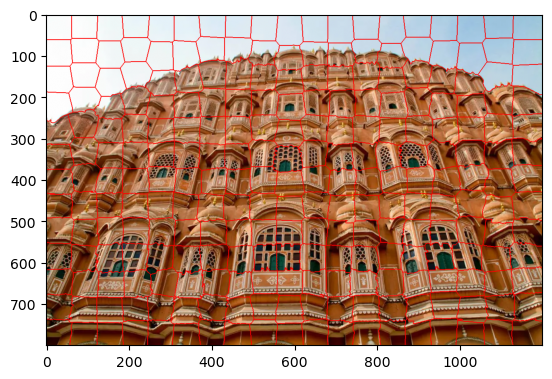

In [26]:
segments_slic = slic(img, n_segments=250, compactness=100)
fig = plt.figure("Superpixels -- %d segments%")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img, segments_slic, color=(1, 0, 0)))

plt.show()

In [25]:
segments_slic = slic(img, n_segments=300, compactness=10)
fig = plt.figure("Superpixels -- %d segments%")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img, segments_slic, color=(1, 0, 0)))

plt.show()

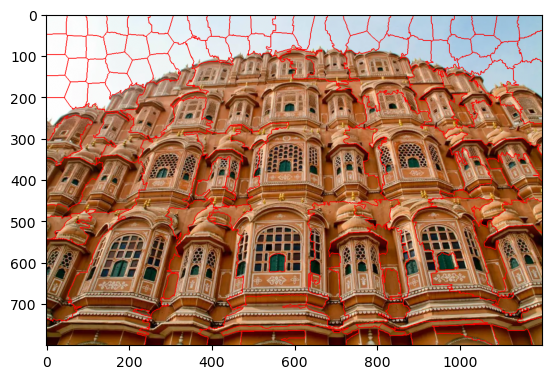

In [30]:
segments_slic = slic(img, n_segments=400, compactness=5)
fig = plt.figure("Superpixels -- %d segments%")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img, segments_slic, color=(1, 0, 0)))

plt.show()

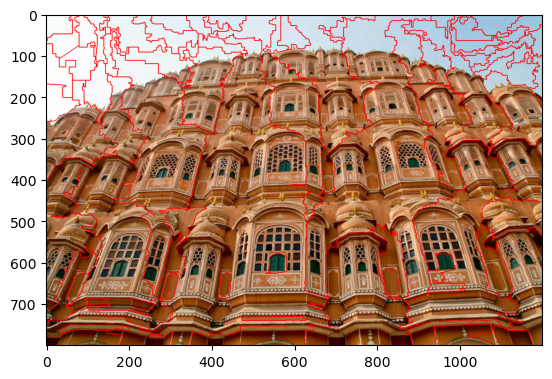

In [31]:
segments_slic = slic(img, n_segments=500, compactness=0.1)
fig = plt.figure("Superpixels -- %d segments%")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img, segments_slic, color=(1, 0, 0)))

plt.show()

- Initially I tried with compactness=100 which resulted in superpixel shape more square/cubic. 
- I feel like compactness = 5 suited the image better than other parameters. As 0.1 just added bunch of noise. 
- The chosen image is complex, but I was glad how n_segments 300 and 400 could give decent results out. 

2) There’s an elephant in the room. Can you find it? Use the “template” template.png
and search for it in the “search image” search.png using color-based NCC (make
sure the standard deviation is “unbiased” with N-1). (Note: the template did NOT
come from the search image.) Assume the origin is in the center of the template
image (Note: there should be a wide border around the search image where the
metrics cannot be computed).
Sort the resulting scores from best to worst. Plot all of the sorted scores (1-D plot)
and show the patches corresponding to the 1st, 2nd, 5th, 10th, 100th, and 500th best
matches. Compare the results. [5 pts]

In [6]:
search = plt.imread('search.png')
template = plt.imread('template.png')

In [7]:
search.shape

(300, 400, 3)

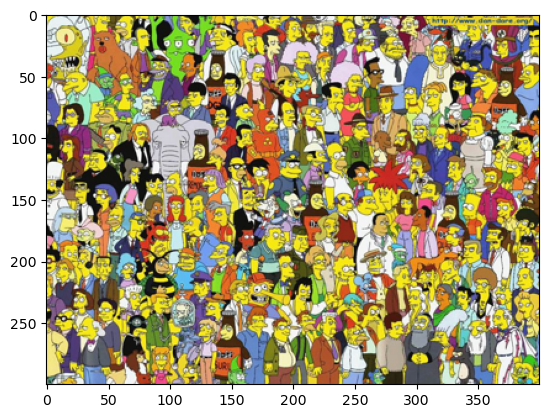

In [8]:
plt.imshow(search)

In [9]:
plt.imshow(template)

In [10]:
image_shape = search.shape

image = np.array(search, dtype=np.float64, copy=False)
pad_width = tuple((width, width) for width in template.shape)
image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=0)

In [11]:
def calc_window_sum(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - window_sum[:-window_shape[0] - 1])
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] - window_sum[:, :-window_shape[1] - 1])
    window_sum = np.cumsum(window_sum, axis=2)
    window_sum = (window_sum[:, :, window_shape[2]:-1] - window_sum[:, :, :-window_shape[2] - 1])
    return window_sum

In [14]:
image_window_sum = calc_window_sum(image, template.shape)
image_window_sum2 = calc_window_sum(image ** 2, template.shape)

template_mean = template.mean()
template_volume = np.prod(template.shape)
template_ssd = np.sum((template - template_mean) ** 2)

xcorr = fftconvolve(image, template[::-1, ::-1, ::-1], mode="valid")[1:-1, 1:-1, 1:-1]

numerator = xcorr - image_window_sum * template_mean

denominator = image_window_sum2
image_window_sum = np.multiply(image_window_sum, image_window_sum)
image_window_sum = np.divide(image_window_sum, template_volume)


denominator -= image_window_sum
denominator *= template_ssd

denominator = np.maximum(denominator, 0) # sqrt of negative number not allowed
denominator = np.sqrt(denominator)
response = np.zeros_like(xcorr, dtype=np.float64)
mask = denominator > np.finfo(np.float64).eps
response[mask] = numerator[mask] / denominator[mask]

In [15]:
slices = []

slices = []
for i in range(template.ndim):
    d0 = template.shape[i] - 1
    d1 = d0 + image_shape[i] - template.shape[i] + 1
    slices.append(slice(d0, d1))
    

In [16]:
result = response[tuple(slices)]
def largest_indices(ary, n):
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [17]:
ind_list = [1, 2, 5, 10, 100, 500]
x_list = []
y_list = []

for t in ind_list:
    ind = largest_indices(result, t)
    x_t, y_t = ind[1][-1], ind[0][-1]
    x_list.append(x_t)
    y_list.append(y_t)
    
ij = np.unravel_index(np.argmax(result), result.shape)
_, x, y = ij[::-1] 

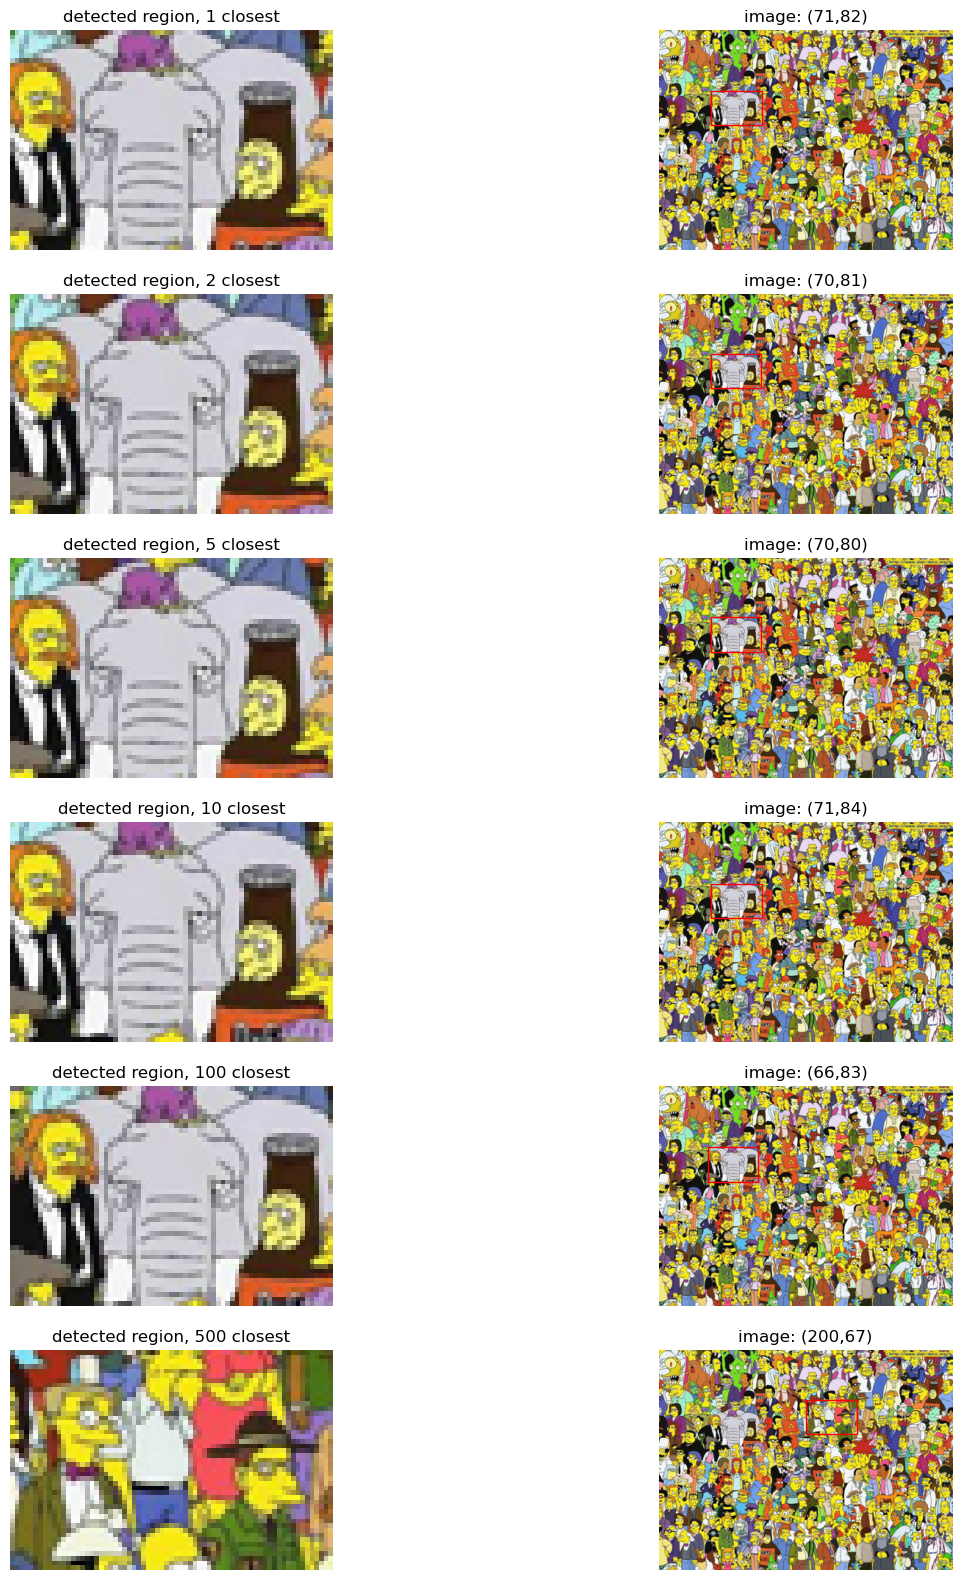

In [18]:
plot_n = 6

fig, axarr = plt.subplots(6, 2, figsize=(15,20))

for i in range(plot_n):
    htemplate, wtemplate, _ = template.shape

    axarr[i, 0].imshow(search[y_list[i]: y_list[i]+htemplate, x_list[i]:x_list[i]+wtemplate])
    axarr[i, 0].set_axis_off()
    axarr[i, 0].set_title(f'detected region, {ind_list[i]} closest')

    axarr[i, 1].imshow(search)
    axarr[i, 1].set_axis_off()
    axarr[i, 1].set_title(f'image: ({x_list[i]},{y_list[i]})')


    rect = plt.Rectangle((x_list[i], y_list[i]), wtemplate, htemplate, edgecolor='r', facecolor='none')

    axarr[i, 1].add_patch(rect)

plt.show()

- I would say Template matching performed fairly well upto 100 closest. 
- It got little shifted on the 100th to the left but was still able to find the elephant. 
- It failed on the 500th closest and shifted wwas too far right. 